In [2]:
import mlxtend
import numpy as np
import pandas as pd
import re

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

import time
from functools import wraps

from scipy import stats

from sklearn.cluster import KMeans, DBSCAN
from sklearn.cluster import k_means_

from sklearn.metrics import pairwise_distances
from sklearn.metrics.pairwise import euclidean_distances, cosine_similarity, cosine_distances

from sklearn.decomposition import PCA

from sklearn.model_selection import learning_curve
from sklearn.preprocessing import StandardScaler  # For scaling dataset
from sklearn.metrics import silhouette_score

import seaborn as sns; sns.set(style="ticks", color_codes=True)

# Resumo

O objetivo deste notbook é executar o trablho da disciplina de Data Mining I. O enunciado pedia que:

* Encontrássemos clusters de filmes semelhantes usando as notas dadas pelos usuários como features do modelo.
* Para lidar com o grande número de dimensões dos vetores de features, deveríamos usar uma transformada PCA para reduzir a dimensão do prodlema.
* Utilizar os algoritmos: KMeans e DBScan para gerar os clusters

A bases de 100k e 1M já haviam sido tratadas no trabalho anterior, por isso nenhum pré-processamento de limpeza dos dados foi feito. A ordem do Notebbok, seguiu o processo de experimentação realmente executado. Caso apenas as conclusões sejam de interesse, a sessão de conclusão resume o que foi encontrado.

# Importando o dataset

dataset depois do tratamento feito para a análise de Market Basket. 

In [3]:
ratingsDF_100k = pd.read_pickle("..\\ProcessedData\\df.pkl")
ratingsDF_1M = pd.read_pickle("..\\ProcessedData\\df_1M.pkl")

visualizando dataset 100k

In [5]:
ratingsDF_100k.head()

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
0,196,242,3,1997-12-04 15:55:49,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,63,242,3,1997-10-01 23:06:30,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,226,242,5,1998-01-04 04:37:51,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,154,242,3,1997-11-10 05:03:55,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,306,242,5,1997-10-10 17:16:33,Kolya (1996),1997-01-24,http://us.imdb.com/M/title-exact?Kolya%20(1996),0,0,0,...,0,0,0,0,0,0,0,0,0,0


visualizando dataset 1M

In [28]:
ratingsDF_1M.head()

,uid,id,rating,timestamp,movie_title,Genres
0,1,1193,5,2000-12-31 22:12:40,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
1,2,1193,5,2000-12-31 21:33:33,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
2,12,1193,4,2000-12-30 23:49:39,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
3,15,1193,4,2000-12-30 18:01:19,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama
4,17,1193,5,2000-12-30 06:41:11,ONE FLEW OVER THE CUCKOO'S NEST (1975),Drama


In [8]:
print("Número de usuários na base 100k %i" % ratingsDF_100k['uid'].nunique())
print("Número de usuários na base 1M %i" % ratingsDF_1M['uid'].nunique())

Número de usuários na base 100k 943
Número de usuários na base 1M 6040


In [9]:
print("Número de filmes na base 100k %i" % ratingsDF_100k['id'].nunique())
print("Número de filmes na base 1M %i" % ratingsDF_1M['id'].nunique())

Número de filmes na base 100k 1664
Número de filmes na base 1M 3706


## Criando os vetores de features dos filmes

Cada filme será representado pelas notas que cada um dos usuários da base deu para aquele filme. O que siginifica que **cada filme será representado por vetores esparsos de tamanho 943**.

Sabemos da exploração que não há duplicatas para a chave **uid, id**, então:

In [20]:
def visualize_ratings_sparsity(ratingsDF):
    ratings_id = ratingsDF.groupby(['id']).aggregate({'rating': len})
    
    print("Moda do número de usuários que viram o filme: %i" % ratings_id.rating.mode())
    print("Média do número de usuários que viram o filme: %i" % ratings_id.rating.mean())
    print("Número de filmes com apenas uma avaliação: %i" % (ratings_id.rating == 1).sum())
    
    plt.figure(),
    plt.subplot(1,2,1)
    ratings_id.rating.hist()
    plt.grid(True)
    plt.title("#usuários que viram o filme")
    plt.xlabel("uid")
    plt.ylabel("freq absoluta")

    plt.subplot(1,2,2)
    ratings_id.boxplot()
    plt.title("Boxplot que viram o filme")
    plt.rcParams['figure.figsize'] = (11,7)
    plt.show()
    
    return ratings_id

Esparsidade do vetor de features na base de 100k 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 59
Número de filmes com apenas uma avaliação: 135


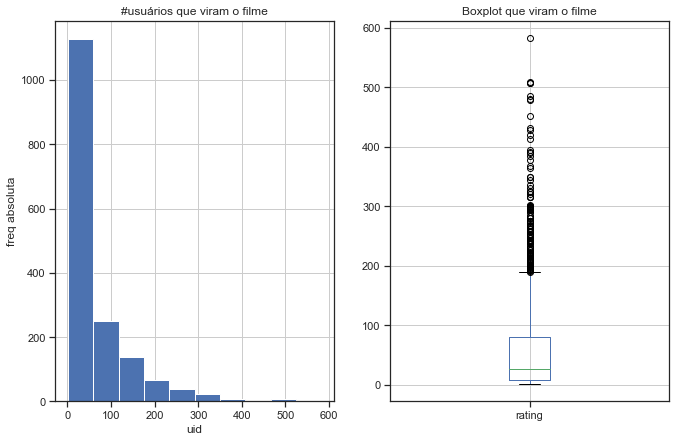

In [21]:
ratings_id_100k = visualize_ratings_sparsity(ratingsDF_100k)

Esparsidade do vetor de features na base de 1M 

Moda do número de usuários que viram o filme: 1
Média do número de usuários que viram o filme: 269
Número de filmes com apenas uma avaliação: 114


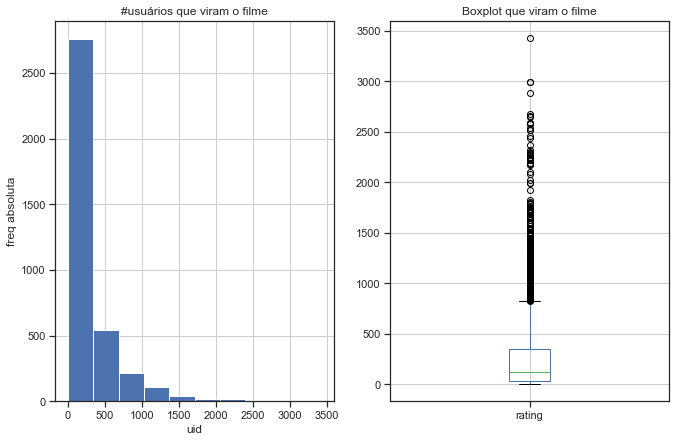

In [22]:
ratings_id_1M = visualize_ratings_sparsity(ratingsDF_1M)

## Filmes mais vistos

Para depois acharmos quais so clusters dos filmes mais populares vamos determinar quais sã eles primeiro. Após a observação dos box plot que mostram o quão esparsos são os vetores das bases, pode-se considerar que um filme popular na base de 100k tem pelo meos 150 visualizações e na base de 1M pelo menos 750

In [19]:
def determine_popular_filmss(ratings_id, threshold):
    popular_film = (ratings_id.rating > threshold)
    popular_ids = popular_film[popular_film]
    print("número de filmes populares %i" % popular_film.sum())
    return popular_ids

Para a base de 100k

In [24]:
popular_ids_100k = popular_ids_100k = determine_popular_filmss(ratings_id_100k, 150)

número de filmes populares 202


In [26]:
ratingsDF_100k[ratingsDF_100k['id'].isin(popular_ids_100k.index)].sample(10)

,uid,id,rating,timestamp,movie_title,release_date,IMDb_URL,unknown,Action,Adventure,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
35080,693,11,4,1997-09-28 21:29:57,Seven (Se7en) (1995),1995-01-01,http://us.imdb.com/M/title-exact?Se7en%20(1995),0,0,0,...,0,0,0,0,0,0,0,1,0,0
92622,690,1090,3,1997-12-03 20:15:38,Sliver (1993),1993-01-01,http://us.imdb.com/M/title-exact?Sliver%20(1993),0,0,0,...,0,0,0,0,0,0,0,1,0,0
50924,157,50,4,1998-02-07 22:29:01,Star Wars (1977),1977-01-01,http://us.imdb.com/M/title-exact?Star%20Wars%2...,0,1,1,...,0,0,0,0,0,1,1,0,1,0
92878,774,1215,1,1998-02-27 05:50:23,Barb Wire (1996),1996-05-03,http://us.imdb.com/M/title-exact?Barb%20Wire%2...,0,1,0,...,0,0,0,0,0,0,1,0,0,0
34331,659,153,4,1998-03-28 00:44:51,"Fish Called Wanda, A (1988)",1988-01-01,http://us.imdb.com/M/title-exact?Fish%20Called...,0,0,0,...,0,0,0,0,0,0,0,0,0,0
58210,561,70,4,1998-01-26 09:57:53,Four Weddings and a Funeral (1994),1994-01-01,http://us.imdb.com/M/title-exact?Four%20Weddin...,0,0,0,...,0,0,0,0,0,1,0,0,0,0
67116,846,110,3,1998-01-04 21:49:28,Operation Dumbo Drop (1995),1995-01-01,http://us.imdb.com/M/title-exact?Operation%20D...,0,1,1,...,0,0,0,0,0,0,0,0,1,0
71427,201,380,1,1998-01-07 02:40:25,Star Trek: Generations (1994),1994-01-01,http://us.imdb.com/M/title-exact?Star%20Trek:%...,0,1,1,...,0,0,0,0,0,0,1,0,0,0
74816,144,223,4,1998-02-21 23:53:17,Sling Blade (1996),1996-11-22,http://us.imdb.com/M/title-exact?Sling%20Blade...,0,0,0,...,0,0,0,0,0,0,0,1,0,0
34924,637,595,3,1997-12-23 19:15:37,"Fan, The (1996)",1996-08-16,"http://us.imdb.com/M/title-exact?Fan,%20The%20...",0,0,0,...,0,0,0,0,0,0,0,1,0,0


In [25]:
popular_ids_1M = popular_ids_100k = determine_popular_filmss(ratings_id_1M, 750)

número de filmes populares 354


In [27]:
ratingsDF_1M[ratingsDF_1M['id'].isin(popular_ids_1M.index)].sample(10)

,uid,id,rating,timestamp,movie_title,Genres
55833,1968,3114,4,2000-11-20 02:31:09,TOY STORY 2 (1999),Animation|Children's|Comedy
538470,3982,2021,2,2000-08-07 04:40:31,DUNE (1984),Fantasy|Sci-Fi
65963,921,2628,4,2000-11-26 02:10:31,STAR WARS: EPISODE I - THE PHANTOM MENACE (1999),Action|Adventure|Fantasy|Sci-Fi
468213,1586,2746,4,2000-11-20 16:39:49,LITTLE SHOP OF HORRORS (1986),Comedy|Horror|Musical
55481,817,3114,5,2000-11-28 05:18:07,TOY STORY 2 (1999),Animation|Children's|Comedy
318135,3790,32,5,2000-08-12 00:19:03,TWELVE MONKEYS (1995),Drama|Sci-Fi
513620,5065,2003,3,2000-07-01 19:15:12,GREMLINS (1984),Comedy|Horror
282935,5791,2599,4,2000-05-12 00:05:50,ELECTION (1999),Comedy
604998,2946,1396,3,2000-12-03 07:14:41,SNEAKERS (1992),Crime|Drama|Sci-Fi
266443,3868,1704,3,2000-08-09 19:35:39,GOOD WILL HUNTING (1997),Drama


# Criando vetores de features

Para fins desse trabalho, foi pedido para que usássemos as notas dadas pelos uuários como features. Outra informaçoes contidas na base poderiam ser usadas como: ano de lançamento e gênero.

In [66]:
def create_features(ratingsDF):
    df_pivoted = pd.pivot_table(ratingsDF, columns=['uid'], values=['rating'], index=['id'], aggfunc=np.max)
    df_pivoted.columns = df_pivoted.columns.get_level_values(1)
    return df_pivoted

In [68]:
%%time
df_features_100k = create_features(ratingsDF_100k)

Wall time: 1min 12s


In [62]:
df_features_100k.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,934,935,936,937,938,939,940,941,942,943
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,4.0,NaN,NaN,4.0,4.0,NaN,NaN,NaN,4.0,...,2.0,3.0,4.0,NaN,4.0,NaN,NaN,5.0,NaN,NaN
2,3.0,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN,...,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0
3,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,3.0,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,4.0,...,5.0,NaN,NaN,NaN,NaN,NaN,2.0,NaN,NaN,NaN
5,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,...,NaN,NaN,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,4.0,NaN,NaN,NaN,NaN,2.0,5.0,3.0,4.0,4.0,...,NaN,NaN,4.0,NaN,4.0,NaN,4.0,4.0,NaN,NaN
8,1.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,5.0,NaN,NaN,NaN
9,5.0,NaN,NaN,NaN,NaN,4.0,5.0,NaN,NaN,4.0,...,NaN,1.0,4.0,5.0,3.0,5.0,3.0,NaN,NaN,3.0


In [72]:
%%time
df_features_1M = create_features(ratingsDF_1M)

Wall time: 11min 51s


In [73]:
df_features_1M.head(10)

uid,1,2,3,4,5,6,7,8,9,10,...,6031,6032,6033,6034,6035,6036,6037,6038,6039,6040
id,,,,,,,,,,,,,,,,,,,,,
1,5.0,NaN,NaN,NaN,NaN,4.0,NaN,4.0,5.0,5.0,...,NaN,4.0,NaN,NaN,4.0,NaN,NaN,NaN,NaN,3.0
2,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,...,NaN,NaN,NaN,NaN,2.0,2.0,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,2.0,NaN,4.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN
7,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,4.0,...,NaN,NaN,NaN,NaN,3.0,NaN,NaN,NaN,NaN,NaN
8,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,5.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
9,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [74]:
# para evitar o retreino das features que pode demorar um pouco especialmete para a base de 1M
df_features_100k.to_pickle('../ProcessedData/temp/df_features_100k.pkl')
df_features_1M.to_pickle('../ProcessedData/temp/df_features_1M.pkl')

## Fill de valores nulos

Os algoritimos que vamos utilizar são sensíveis aos valores nulos. Para diminuir esse efeito, podemos substituir zeros pela média das notas dos filmes desconsiderando os valores 0 (que são NAN na verdade);

In [53]:
def fillNa_with_non_na_avg_rating_for_film(df_pivoted): 
    # Obs: a função *fillna* por linha não está implementada no Pandas, por isso as transposições
    filmMeanRating = df_pivoted.mean(axis=1)
    df_pivoted_ = df_pivoted.T.fillna(filmMeanRating).T
    return df_pivoted_

In [71]:
%%time
df_features_100k_ = fillNa_with_non_na_avg_rating_for_film(df_features_100k)

Wall time: 323 ms


In [76]:
df_features_100k_.T.describe()

id,1,2,3,4,5,6,7,8,9,10,...,1672,1673,1674,1675,1676,1677,1678,1679,1681,1682
count,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,943.000000,...,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0,943.0
mean,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
std,0.642041,0.359043,0.372773,0.453487,0.284302,0.212022,0.632690,0.482161,0.586278,0.309907,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
min,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
25%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
50%,3.878319,3.206107,3.033333,3.550239,3.302326,3.576923,3.798469,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
75%,4.000000,3.206107,3.033333,3.550239,3.302326,3.576923,4.000000,3.995434,3.896321,3.831461,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0
max,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,5.000000,...,2.0,3.0,4.0,3.0,2.0,3.0,1.0,3.0,3.0,3.0


In [75]:
%%time
df_features_1M_ = fillNa_with_non_na_avg_rating_for_film(df_features_1M)

Wall time: 761 ms


O data to enrich, será usado para mostrar os nomes e outras informações cadastrais dos filmes

## DataSet Cadastral

Pode-se recompor a base cadastral de filmes a partir das bases de ratings fazendo-se uma agregação. Isso evita que tenhamos que refazer reprocessametos já feitos na composição da base de ratings.

In [77]:
to_enrich_100k = ratingsDF_100k.groupby('id').agg(
    {'timestamp':'first',
     'id':'first',
     'movie_title':'first', 
     'release_date':'first',
     'unknown':'first', 
     'Action':'first', 
     'Adventure':'first', 
     'Animation':'first', 
     'Children\'s':'first',
       'Comedy':'first', 
     'Crime':'first', 
     'Documentary':'first', 
     'Drama':'first', 
     'Fantasy':'first', 
     'Film-Noir':'first',
       'Horror':'first', 
     'Musical':'first', 
     'Mystery':'first', 
     'Romance':'first', 
     'Sci-Fi':'first', 
     'Thriller':'first', 
     'War':'first',
    'Western':'first'
    })

In [ ]:
to_enrich.head(5)

In [ ]:
to_enrich_1M = ratingsDF_1M.groupby('id').agg(
    {'timestamp':'first', 
     'id':'first',
     'movie_title':'first', 
     'Genres':'first',
    })

In [ ]:
to_enrich_1M.head(5)

# Decomposição do vetor de features

In [101]:
def get_pca(df_flattern, pca_dim):
    
    pca = PCA(n_components=pca_dim).fit(df_flattern)
    df_pca = pd.DataFrame(pca.transform(df_flattern))
    
    return df_pca, pca

def visualize_pca(df_pca, pca):
    pca_dim = pca3.n_components
    cumulativeVar = pd.Series(pca.explained_variance_ratio_.cumsum())
    
    plt.figure()
    cumulativeVar.plot()
    
    plt.grid(True)
    plt.title("soma cumulativa das variâncias")
    plt.xlabel("#PCA components")
    plt.ylabel("variância")
    plt.show()
    
    # plt.figure().gca(projection='3d')
    plt.figure()
    plt.scatter(df_pca[0], df_pca[1])
    plt.grid(True)
    plt.title("filmes")
    plt.xlabel("pca_0")
    plt.ylabel("pca_1")
    plt.show()

## PCA para a base de 100K

In [103]:
df_pca_100k, pca_full_100k = get_pca(df_features_100k_, None)

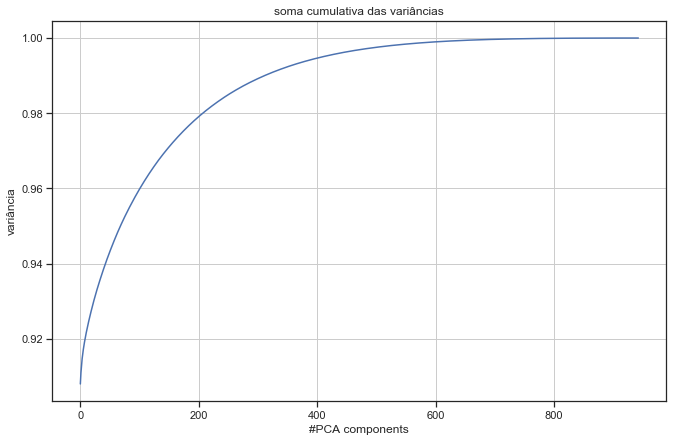

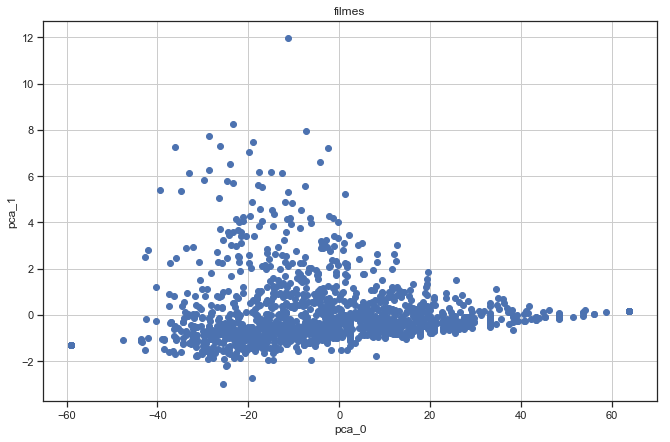

In [104]:
visualize_pca(df_pca_100k, pca_full_100k)

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [115]:
# limpando a memória
pca_full_100k = None

In [105]:
df_pca_100k, pca_3_100k = get_pca(df_features_100k_, 3)

In [108]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_3_100k.n_components, pca_3_100k.explained_variance_ratio_.sum())) 

energia conservada pelas 3 primeiras componentes do PCA 0.912999


Trabalhar com um número maior de componentes dificultaria a visualização e a ordem de grandeza das variâncias cai muito ao longo dos eixos

## PCA para a base de 1M

In [112]:
df_pca_1M, pca_full_1M = get_pca(df_features_1M_, None)

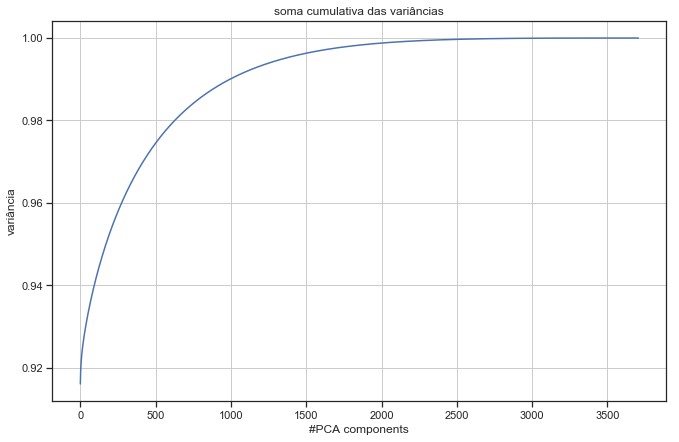

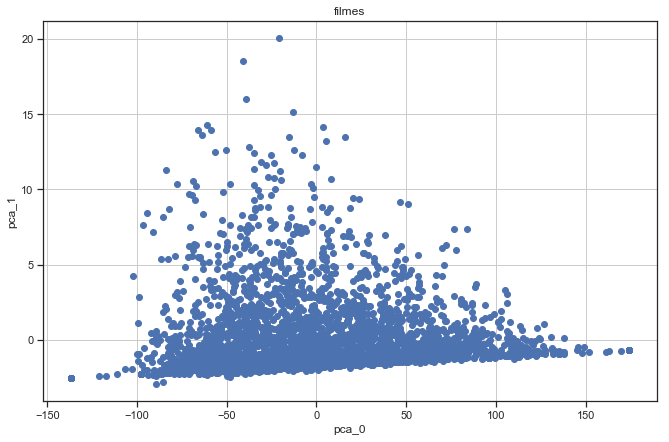

In [113]:
visualize_pca(df_pca_1M, pca_full_1M)

In [114]:
# limpando a memória
pca_full_1M = None

Observando o gráfico, percbe-se a concentração de enrgia nas primeiras componentes com apenas 3 temos que:

In [116]:
df_pca_1M, pca_3_1M = get_pca(df_features_1M_, 3)

In [118]:
print("energia conservada pelas %i primeiras componentes do PCA %f" % (pca_3_1M.n_components, pca_3_1M.explained_variance_ratio_.sum())) 

energia conservada pelas 3 primeiras componentes do PCA 0.919143


Novamente trabalhar com um número maior de componentes dificultaria a visualização e a ordem de grandeza das variâncias cai muito ao longo dos eixos

# Clusterização

Posdemos executar a clusterização no espaço não transformado pelo PCA enquanto isso não gerar problemas de desempenho. Pode-se usar o PCA para fazer a projeção para 2D e faciliar a visualização dos clustes

## Kmeans usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar o número de clusters

In [124]:
def loss_vs_n_clusters(n_clusters_range, df_for_clustering):
    scores = []
    time_elapsed = []
    
    for n in n_clusters_range:
        start_time = time.time()
        kmeans = KMeans(n_clusters=int(n)).fit(df_for_clustering)
        elapsed_time = time.time() - start_time
        scores.append(kmeans.inertia_)
        time_elapsed.append(elapsed_time)
    
    plt.figure(),
    plt.subplot(2,1,1)
    plt.plot( n_clusters_range, scores)
    plt.grid(True)
    plt.title("score x #clusters")
    plt.ylabel("score")
    plt.subplot(2,1,2)
    plt.plot( n_clusters_range, time_elapsed)
    plt.grid(True)
    plt.xlabel("#clusters")
    plt.ylabel("time_elapsed")
    plt.show()
    
    return scores, time_elapsed

In [145]:
def visualize_kmeans(df):

    filmsInClusterCount = pd.Series(data=df.groupby(['cluster']).count()[0])
    plt.figure(),
    filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
    plt.xlabel("cluster")
    plt.grid(True)
    plt.ylabel("freq. absoluta")
    plt.title('distribuição nos clusters')
    plt.show()
    
    plt.figure(),
    g = sns.pairplot( df, hue="cluster", x_vars=df.columns, y_vars=df.columns)
    plt.show()

In [148]:
def enrich_columns(df, to_enrich):
    df_full = pd.concat([df, to_enrich], axis=1, join='inner')
    df_full[df_full['cluster'] == 0].head(10)
    df_full = df_full.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
    return df_full

### Base de 100k

#### Treinamento

Para determinar o número de clusters, procuramos por um joelho na gráfico de loss (norma L@) vs número de clusters

In [122]:
th_min = 0
th_max = 2
n_clusters_range = np.rint(np.logspace(th_min,th_max,num=30))

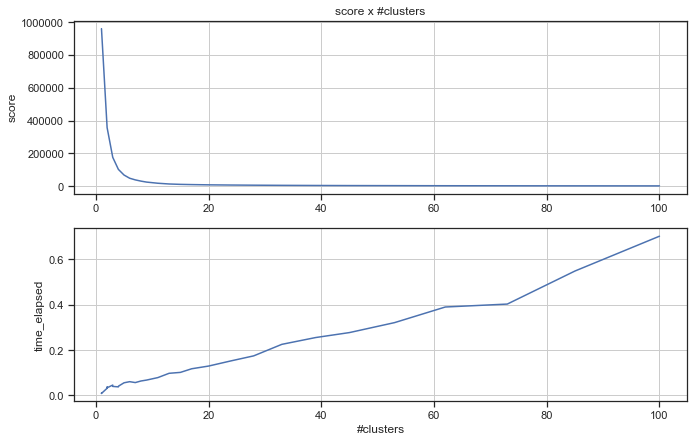

In [125]:
scores_100k, time_elapsed_100k = loss_vs_n_clusters(n_clusters_range, df_pca_100k)

Por inspeção, há um joelho entre 10 e 20, vou repetir a análise para aumentar o range de 10 a 20

In [129]:
n_clusters_range = np.linspace(5,20,num=10)

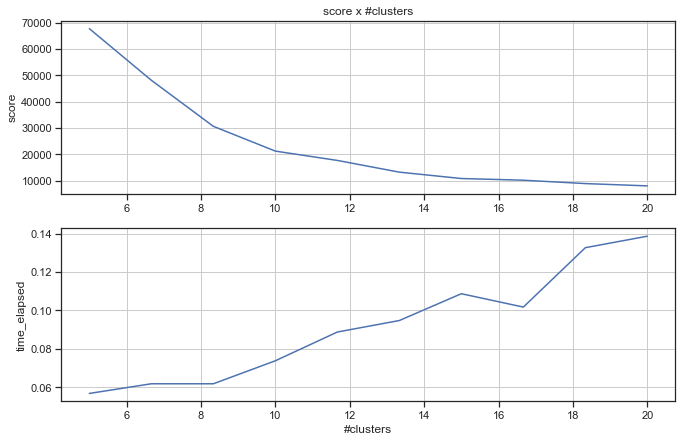

In [130]:
scores_100k, time_elapsed_100k = loss_vs_n_clusters(n_clusters_range, df_pca_100k)

Por inspeção n=10, parece uma boa definição para o joelho

In [136]:
n_100k = 10
kmeans_100k = KMeans(n_clusters=n_100k).fit(df_pca_100k)

# adding cluster column to dataset
cluster_labels_100k = kmeans_100k.labels_
df_100k = df_pca_100k.copy()
df_100k['cluster'] = cluster_labels_100k

#### Visualizando so resultados

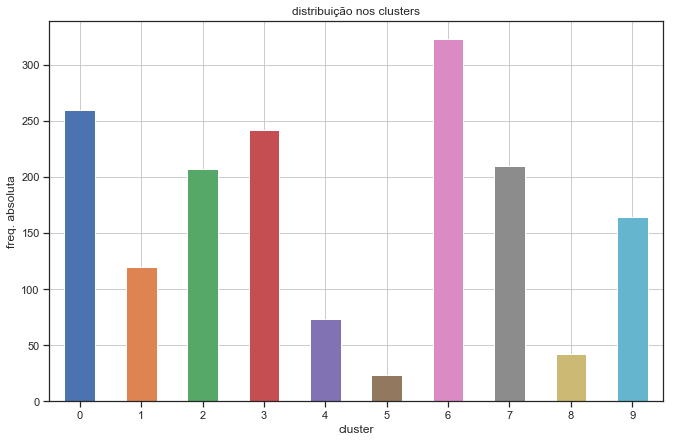

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

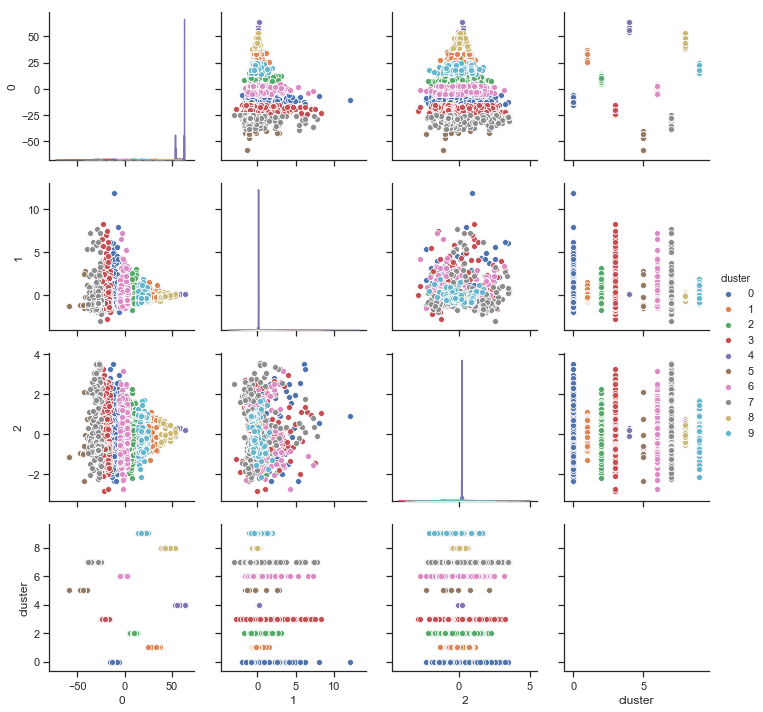

In [147]:
visualize_kmeans(df_100k)

##### Observação
> Aparentemente, os clusters usados separaram os dados (para a maioria dos clusters), com planos ortogonais ao eixo 0 do PCA.

In [149]:
df_full_100k = enrich_columns(df_100k, to_enrich_100k)

In [150]:
df_full_100k.head(5)

,pca_0,pca_1,pca_2,cluster,timestamp,id,movie_title,release_date,unknown,Action,...,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
1,-4.009658,2.882212,2.483214,6,1998-02-17 17:28:52,1,Toy Story (1995),1995-01-01,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1.331258,1.437463,-0.431172,6,1997-09-30 16:14:13,2,GoldenEye (1995),1995-01-01,0,1,...,0,0,0,0,0,0,0,1,0,0
3,-14.598549,1.232490,0.178445,0,1997-11-08 04:30:41,3,Four Rooms (1995),1995-01-01,0,0,...,0,0,0,0,0,0,0,1,0,0
4,-6.915478,1.877836,-1.029438,0,1998-02-03 15:18:17,4,Get Shorty (1995),1995-01-01,0,1,...,0,0,0,0,0,0,0,0,0,0
5,-15.333143,-0.715074,-1.509999,3,1998-03-03 06:29:36,5,Copycat (1995),1995-01-01,0,0,...,0,0,0,0,0,0,0,1,0,0


# Refazer - Limpar

Intra cluster coesion

In [377]:
intra_cluster_dist = []
dists_sum = []
for c in range(0, n_):
    in_cluster = df_full[df_full.cluster == c]
    centroid = np.array(kmeans.cluster_centers_[c]).reshape(1,-1)
    dists = euclidean_distances(in_cluster[["pca_0","pca_1","pca_2"]], centroid)
    sqr = np.dot(dists.reshape(-1),dists.reshape(-1))
    dists_sum.append(sqr)
    dist = dists.mean()
    cluster_sz = len(in_cluster)
    intra_cluster_dist.append([c,dist,cluster_sz])
intra_cluster_dist = pd.DataFrame(columns=['cluster', 'mean_dist', 'cluster_sz'], data=intra_cluster_dist)

Os clusters em ordem de coesão

In [378]:
intra_cluster_dist.sort_values(['mean_dist'])

,cluster,mean_dist,cluster_sz
5,5,1.712612,76
8,8,2.014065,223
2,2,2.652628,192
7,7,2.776971,223
3,3,2.861866,218
6,6,3.126926,206
4,4,3.447532,178
9,9,3.599732,201
1,1,4.737666,106
0,0,8.031815,23


**Conclusão**
> os clusters 9 e 7 são pequenos e pouco coesos, o que pode significar que não sejam clusters de fato, mas apenas 'outliers'

In [379]:
for c in range(0, n_):
    in_cluster = df_full[df_full.cluster == c]
    print("Cluster %i" % c)
    print(in_cluster.sample(n=10)['movie_title'])
    in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)

Cluster 0
479               Vertigo (1958)
1456       Beat the Devil (1954)
1179     Man of the House (1995)
404             Pinocchio (1940)
1387                 Fall (1997)
1112                 Cobb (1994)
1627            Wife, The (1995)
63      Santa Clause, The (1994)
1489              Chasers (1994)
1438              Panther (1995)
Name: movie_title, dtype: object
Cluster 1
1642                             Some Mother's Son (1996)
1349                               Mille bolle blu (1993)
379     Tales From the Crypt Presents: Demon Knight (1...
1645                              Butcher Boy, The (1998)
1585                                American Dream (1990)
1077                                Love and a .45 (1994)
1244                                         Metro (1997)
1450                               Golden Earrings (1947)
1647                                       Hana-bi (1997)
1248                                         Blink (1994)
Name: movie_title, dtype: object
Clus

### Onde estão os filmes populares?

In [380]:
kmeans_populares = df_full[df_full['id'].isin(popular_ids.index)]

In [381]:
filmsInClusterCount = pd.Series(data=kmeans_populares.groupby(['cluster']).count()['pca_0'])

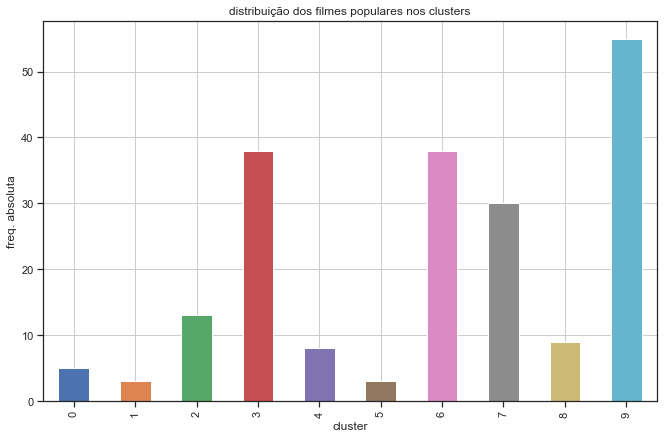

In [382]:
plt.figure()
filmsInClusterCount.plot.bar()
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição dos filmes populares nos clusters')
plt.show()

**conclsão**
> Hà filmes populares em todos os clusters, mas são mais frequentes nos clusters 0, 2, 5 e 8

In [383]:
for c in range(0, n_):
    in_cluster = kmeans_populares[kmeans_populares.cluster == c]
    if len(in_cluster)> 2:
        print("filmes populares do Cluster %i" % c)
        print(in_cluster.sample(n=2)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)

filmes populares do Cluster 0
315                          Apt Pupil (1998)
168    Monty Python and the Holy Grail (1974)
Name: movie_title, dtype: object
filmes populares do Cluster 1
246            Chasing Amy (1997)
751    Tomorrow Never Dies (1997)
Name: movie_title, dtype: object
filmes populares do Cluster 2
79     Fugitive, The (1993)
258          Contact (1997)
Name: movie_title, dtype: object
filmes populares do Cluster 3
285    Secrets & Lies (1996)
410           Kingpin (1996)
Name: movie_title, dtype: object
filmes populares do Cluster 4
111    Truth About Cats & Dogs, The (1996)
402                           Ghost (1990)
Name: movie_title, dtype: object
filmes populares do Cluster 5
845    That Thing You Do! (1996)
433              Heathers (1989)
Name: movie_title, dtype: object
filmes populares do Cluster 6
176          Aliens (1986)
257    Men in Black (1997)
Name: movie_title, dtype: object
filmes populares do Cluster 7
117    Rock, The (1996)
367     Clueless (1995)
N

## DBScan usando correlação como medida de dessimilaridade

In [385]:
dataset_corr = pairwise_distances(df_for_clustering, metric='correlation')

### range para o ajuste de EPS

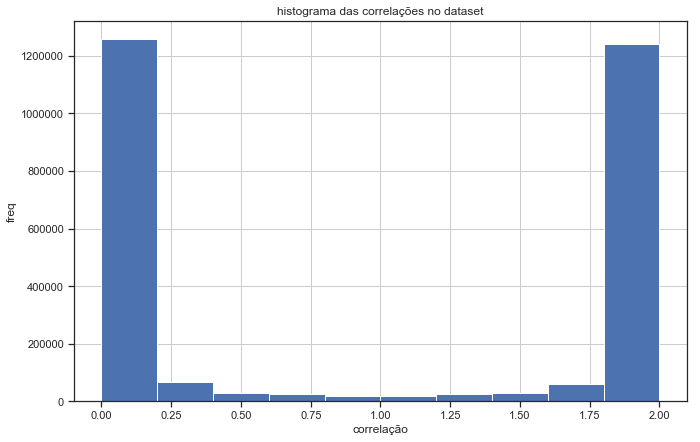

In [386]:
distis_corr = pd.Series(dataset_corr.reshape(-1))
plt.figure()
distis_corr.hist()
plt.title('histograma das correlações no dataset')
plt.xlabel('correlação')
plt.ylabel('freq')
plt.show()

a partir do histograma, imagino que um valor de eps razoável seja ordens de grandeza abixo de 0.25

### treinamento

In [387]:
dbscan = DBSCAN(eps=.0025, min_samples=4, metric='correlation').fit(df_for_clustering)

In [388]:
df_clustered = df_for_clustering.copy()
df_clustered['cluster'] = dbscan.labels_

num_clusters_dbscan = np.max(dbscan.labels_)

In [389]:
df_full2 = pd.concat([df_clustered, to_enrich], axis=1, join='inner')
df_full2 = df_full2.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
dbscan_populares = df_full2[df_full2['id'].isin(popular_ids.index)]

### Visualizando so resultados

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


<Figure size 792x504 with 0 Axes>

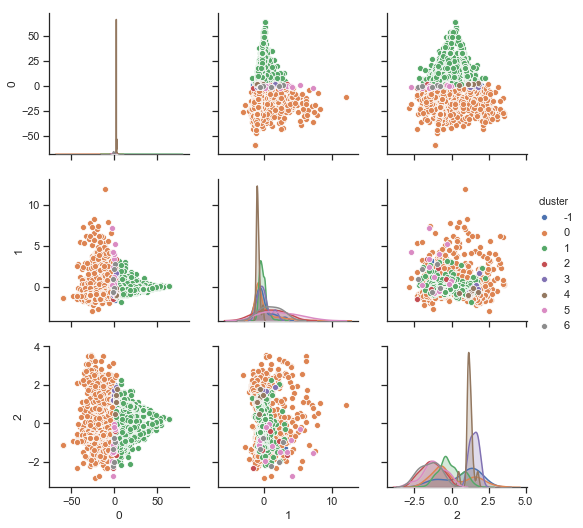

In [390]:
plt.figure()
g = sns.pairplot( df_clustered, hue="cluster", x_vars=df_for_clustering.columns, y_vars=df_pca.columns)
plt.show()

após alguns testes, resolvi ficar com esses valores de eps e min_sample. Reaparei que a tendência é gerar dois grandes grupos separados por pequenos grupos que se distribuem ao longo do de um eixo quase paralelo a dimensão 1 do PCA

In [391]:
for c in range(0, n_):
    in_cluster = df_full2[df_full2.cluster == c]
    print("Cluster %i" % c)
    if len(in_cluster) > 0 :
        sz = (10, len(in_cluster))[len(in_cluster) < 10]
        print(in_cluster.sample(n=sz)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_dbscan.csv" % c)

Cluster 0
1184        Endless Summer 2, The (1994)
1616                 Desert Winds (1995)
142      Bedknobs and Broomsticks (1971)
1139                      Hackers (1995)
626           So Dear to My Heart (1949)
792         Bullets Over Broadway (1994)
507     Streetcar Named Desire, A (1951)
700                Miami Rhapsody (1995)
573                Body Snatchers (1993)
910                  Nil By Mouth (1997)
Name: movie_title, dtype: object
Cluster 1
1276                        Sunset Park (1996)
820                           Space Jam (1996)
982                        Maximum Risk (1996)
1644                   Sudden Manhattan (1996)
898                        Postman, The (1997)
816     Candyman: Farewell to the Flesh (1995)
801                   Air Up There, The (1994)
262               In the Company of Men (1997)
1236          Other Voices, Other Rooms (1997)
767                      Addiction, The (1995)
Name: movie_title, dtype: object
Cluster 2
818                     

### Onde estão os filmes populares?


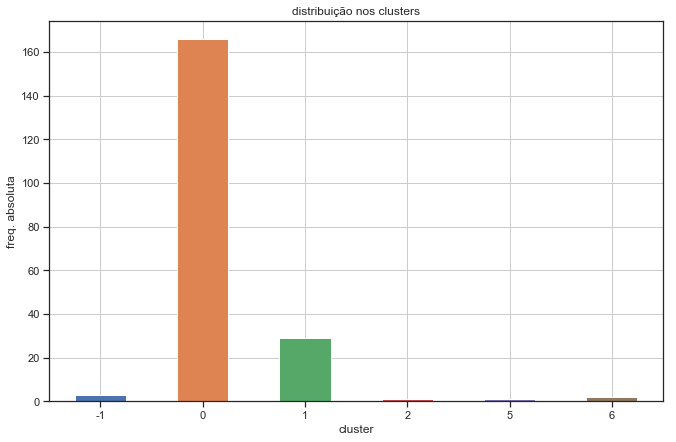

In [392]:
filmsInClusterCount = pd.Series(data=dbscan_populares.groupby(['cluster']).count()['pca_0'])
plt.figure(),
filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição nos clusters')
plt.show()

In [393]:
for c in range(0, n_):
    in_cluster = dbscan_populares[dbscan_populares.cluster == c]
    if len(in_cluster) > 0:
        sz = (5, len(in_cluster))[len(in_cluster) < 5]
        print("filmes populares do Cluster %i" % c)
        print(in_cluster.sample(n=sz)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_kmeans.csv" % c)

filmes populares do Cluster 0
186                       Blues Brothers, The (1980)
227    Star Trek VI: The Undiscovered Country (1991)
367                                  Clueless (1995)
31                               Crimson Tide (1995)
147                  Long Kiss Goodnight, The (1996)
Name: movie_title, dtype: object
filmes populares do Cluster 1
144                        Die Hard (1988)
751             Tomorrow Never Dies (1997)
566        Clear and Present Danger (1994)
111    Truth About Cats & Dogs, The (1996)
28                        Apollo 13 (1995)
Name: movie_title, dtype: object
filmes populares do Cluster 2
321    Mother (1996)
Name: movie_title, dtype: object
filmes populares do Cluster 5
340    Boogie Nights (1997)
Name: movie_title, dtype: object
filmes populares do Cluster 6
319    Everyone Says I Love You (1996)
66      While You Were Sleeping (1995)
Name: movie_title, dtype: object


## DBScan usando a norma L2 como medida de dessimilaridade

Primeiro devemos determinar os hiperparâmetros
1. **eps**: The maximum distance between two samples for them to be considered as in the same neighborhood.
2. **min_samples**: The number of samples (or total weight) in a neighborhood for a point to be considered as a core point. This includes the point itself.

### range de EPS

Vou me basear nos valores típicos de distâncias no dataset

In [394]:
dists = pd.Series(euclidean_distances(df_for_clustering, df_for_clustering).reshape(-1))

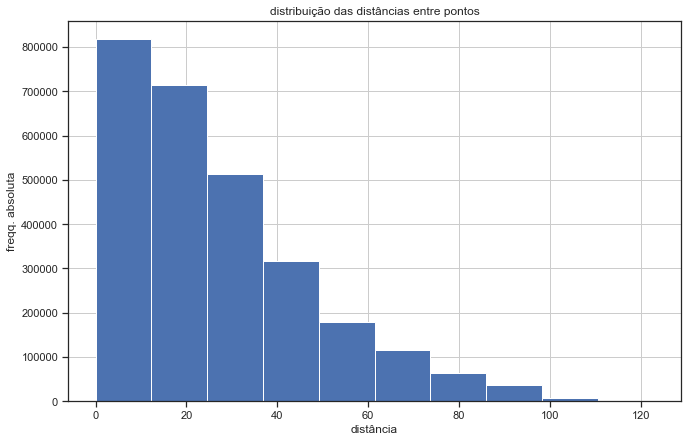

In [395]:
plt.figure()
pd.Series(dists).hist()
plt.title('distribuição das distâncias entre pontos')
plt.xlabel('distância')
plt.ylabel('freqq. absoluta')
plt.show()

In [396]:
dists.describe()

count    2.768896e+06
mean     2.676609e+01
std      2.092899e+01
min      0.000000e+00
25%      1.029825e+01
50%      2.166054e+01
75%      3.778800e+01
max      1.228072e+02
dtype: float64

**Conclusão**
> vou fazer esse parâmetro variar dentro do primeiro quartil, ou seja, entre 0 e 10

### Treinamento

In [397]:
dbscan = DBSCAN(eps=1, min_samples=10).fit(df_for_clustering)

In [398]:
df_clustered = df_for_clustering.copy()
df_clustered['cluster'] = dbscan.labels_

num_clusters_dbscan = np.max(dbscan.labels_)

In [399]:
df_full2 = pd.concat([df_clustered, to_enrich], axis=1, join='inner')
df_full2 = df_full2.rename(mapper={0:'pca_0', 1:'pca_1', 2:'pca_2'}, axis='columns')
dbscan_populares = df_full2[df_full2['id'].isin(popular_ids.index)]

### Visualizando so resultados

C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kde.py:488: RuntimeWarning: invalid value encountered in true_divide
  binned = fast_linbin(X, a, b, gridsize) / (delta * nobs)
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\statsmodels\nonparametric\kdetools.py:34: RuntimeWarning: invalid value encountered in double_scalars
  FAC1 = 2*(np.pi*bw/RANGE)**2
C:\Users\souza\Anaconda3\envs\movielens_env\lib\site-packages\numpy\core\fromnumeric.py:83: RuntimeWarning: invalid value encountered in reduce
  return ufunc

<Figure size 792x504 with 0 Axes>

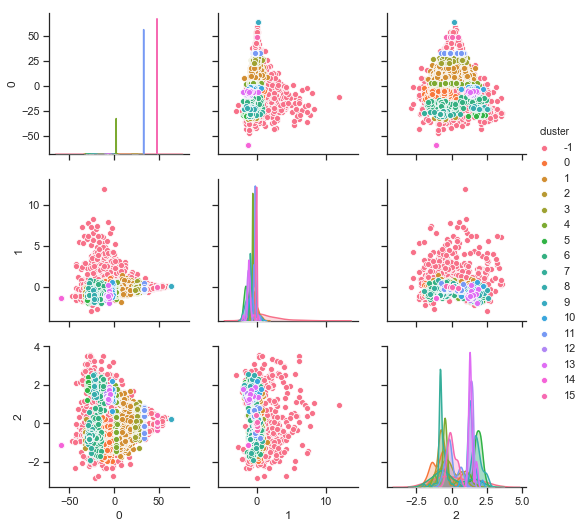

In [400]:
plt.figure()
g = sns.pairplot( df_clustered, hue="cluster", x_vars=df_for_clustering.columns, y_vars=df_pca.columns)
plt.show()

In [401]:
filmsInClusterCount = pd.Series(data=df_clustered.groupby(['cluster']).count()[0])

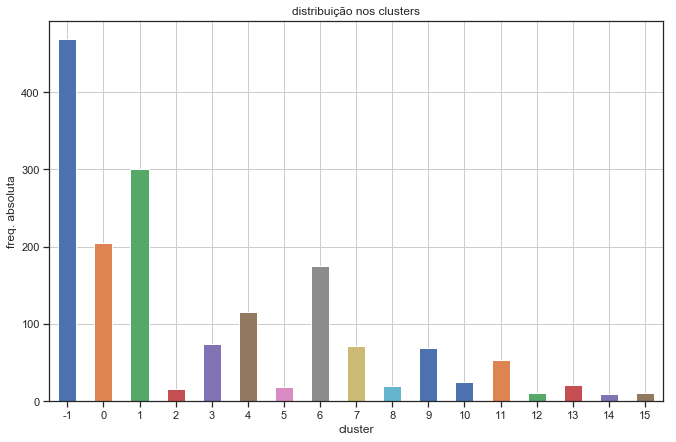

In [402]:
plt.figure(),
filmsInClusterCount.plot.bar(x='index', y='cluster', rot=0)
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição nos clusters')
plt.show()

**Conclusão**
> A ausência do centroide dificulta um pouco a avaliação do que seria a coesão intra-cluster.
> Após algumas tentativas varrendo manualmente os parâmetros do algorítimo, achei que os clusters acima eram significativos em termos de número de filmes no cluster. Observei que:
> 
> * Se diminuimos o eps, mantendo-se o mesmo valor de min_samples, o grupo 0 aumenta e o grupo -1 (ruído) diminui
> * Se mantemos o valor de eps fixo e aumentamos o valor de min_samples, o número de clusters diminui e o tamanho do grupo -1 (ruído) também aumenta.
> De modo geral, eu variei o valor de epsc até obter clusters em grande número (> 20) e depois para um valor baixo de min_samples e depois aumentei o valor de min_samples pra reduzir os clusters criadoss.

In [404]:
for c in range(0, n_):
    in_cluster = df_full2[df_full2.cluster == c]
    print("Cluster %i" % c)
    if len(in_cluster) > 0 :
        sz = (10, len(in_cluster))[len(in_cluster) < 10]
        print(in_cluster.sample(n=sz)['movie_title'])
        in_cluster.to_csv("../ProcessedData/clustering/10k/cluster_%i_dbscan.csv" % c)

Cluster 0
1177              Dunston Checks In (1996)
1164               Zeus and Roxanne (1997)
1317    Journey of August King, The (1995)
454         Bastard Out of Carolina (1996)
877                  Excess Baggage (1997)
324                    Lost Highway (1997)
293                   Donnie Brasco (1997)
542                      Pocahontas (1995)
837                   Meet John Doe (1941)
1116             Mark of Zorro, The (1940)
Name: movie_title, dtype: object
Cluster 1
1016                                  Con Air (1997)
391                          Last Action Hero (1993)
942             What's Love Got to Do with It (1993)
1322                   Metisse (Café au Lait) (1993)
1562    Eye of Vichy, The (Oeil de Vichy, L') (1993)
772                                      Kids (1995)
1293                                 Star Kid (1997)
1151                        Original Gangstas (1996)
1168                            Little Buddha (1993)
534                                 Trav

### Onde estão os filmes populares?

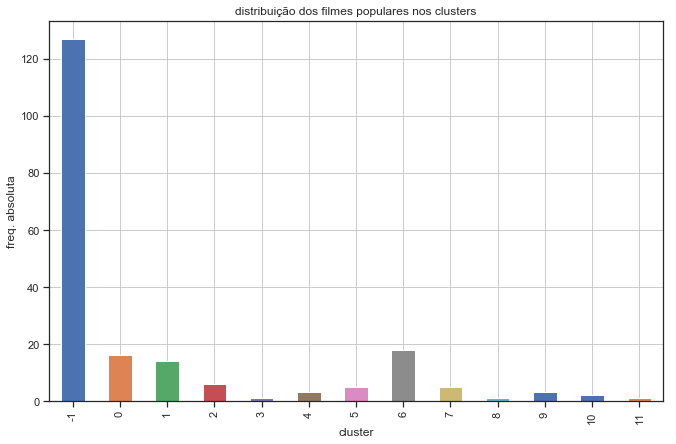

In [405]:
filmsInClusterCount = pd.Series(data=dbscan_populares.groupby(['cluster']).count()['pca_0'])
plt.figure()
filmsInClusterCount.plot.bar()
plt.xlabel("cluster")
plt.grid(True)
plt.ylabel("freq. absoluta")
plt.title('distribuição dos filmes populares nos clusters')
plt.show()

**conclsão**
> Os filmes poplares são mais frequentes no cluster 0 que parece ter concentrado todos eles

In [406]:
for c in range(0, num_clusters_dbscan):
    in_cluster = dbscan_populares[dbscan_populares.cluster == c]
    print("filmes populares cluster %i" % c)
    if len(in_cluster) > 0:
        sz = (4, len(in_cluster))[len(in_cluster) < 4]
        print(in_cluster.sample(n=sz)['movie_title'])

filmes populares cluster 0
248    Grosse Pointe Blank (1997)
742                 Ransom (1996)
527                 Gandhi (1982)
326              G.I. Jane (1997)
Name: movie_title, dtype: object
filmes populares cluster 1
402                           Ghost (1990)
111    Truth About Cats & Dogs, The (1996)
137                       Big Night (1996)
77                        Firm, The (1993)
Name: movie_title, dtype: object
filmes populares cluster 2
22                                     Braveheart (1995)
164                                    Abyss, The (1989)
474    Dr. Strangelove or: How I Learned to Stop Worr...
191                                       Amadeus (1984)
Name: movie_title, dtype: object
filmes populares cluster 3
121    Independence Day (ID4) (1996)
Name: movie_title, dtype: object
filmes populares cluster 4
83     Much Ado About Nothing (1993)
568                     Speed (1994)
327                  Cop Land (1997)
Name: movie_title, dtype: object
filmes populares

# Conclusão

## Na Base de 100k

**Vetores de features e PCA**

Os vetores de features (notas dadas por todos os usuários para o filme) realmente eram esparsos como se esperava. A nédia dos filmes recebeu 59 notas, mas a distribição do número de usuários que deu nota pra os filmes é altamente assimétrica e a moda da distribuição é 1. Por isso, o PCA reduziu bastante as dimensões do problema e 3 componentes representam quase 90% da energia total dos vetores de features. Com a dimensão reduzida, foi possível rodar os alogoritmos em tempo viável.

Os filmes populares, que foram definidos com aqueles com um grande número de notas diferentes de 0. Utilizei o box plot para determinar um limiar de 100 para esses filmes, o que faz com que 333 filmes sejam considerados populares.

**Clusterização KMeans**

A função de loss (somatório das distâncias ao quadrado dos pontos aos centróides de seus clusters) apresentou um "joeçho" em 10 clusters e por isso esse foi o número de clusters que foi utilizado. Os clusters obtidos pelo Kmenas
são paralelos a dimensão 0 do PCA (a de maior variância) e, a exceção de uns poucos, são formados por um grande número de filmes.

O algoritmo parece distribuiu os filmes populares entre os clusters. Eles se revelaram mais frequentes nos clusters 0, 5 e 2 que são clusters com uma grande quantidade de filmes. 

**Clusterização DBScan**

o ajuste dos hiper-parâmetros do algoritmo DBScan foi menos sistemático já que a ausência do conceito de uma função de loss que seja minimizada dificulta essa avaliação. O que se observou foi que:

* Se diminuimos o eps, mantendo-se o mesmo valor de min_samples, o grupo 0 aumenta e o grupo -1 (ruído) diminui
* Se mantemos o valor de eps fixo e aumentamos o valor de min_samples, o número de clusters diminui e o tamanho do grupo -1 (ruído) também aumenta.

O espaço de features abstrato, isto é, a transformada PCA dos vetores de features, dificultou bastante a escolha de parâmetros adequados.  De modo geral, eu variei o valor de epsc até obter clusters em grande número (> 20) e depois para um valor baixo de min_samples e depois aumentei o valor de min_samples pra reduzir os clusters criadoss.

Reparei que a tendência do algoritimo foi gerar dois grandes clusters nas extremidades da nuvem de dados separados por pequenos clusters em um "equador". 

O algoritmo não parece sensível aos filmes populares já que a maioria deles caiu no grupo de ruído (-1).